<a href="https://colab.research.google.com/github/qzlinqian/6_869_project_med_seg/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Load data and basic setup

In [1]:
use_gdrive = True  # want to use data in my google drive

In [2]:
import os
from tqdm import tqdm

if use_gdrive:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

  data_dir = "/content/drive/MyDrive/data"
else:
  data_dir = "./data"

datasets_dir = data_dir + '/Task03_Liver'

os.makedirs(datasets_dir, exist_ok=True)

training_imgs_dir = datasets_dir + '/imagesTr'
training_labels_dir = datasets_dir + '/labelsTr'
test_imgs_dir = datasets_dir + '/imagesTs'
two_d_imgs_dir = datasets_dir + '/2d_data/images/'
two_d_labels_dir = datasets_dir + '/2d_data/labels/'


Mounted at /content/drive


In [3]:
import nibabel as nib  # to read .nii.gz files
import numpy as np
import matplotlib.pyplot as plt

### To clone from repo

In [4]:
username = 'qzlinqian'
repository = '6_869_project_med_seg'
git_token =  ''

In [5]:
!git clone https://{git_token}@github.com/{username}/{repository} temp
%cp -r temp/* .
%rm -rf temp
%rm segmentation.ipynb

Cloning into 'temp'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 73 (delta 0), reused 3 (delta 0), pack-reused 70
Unpacking objects: 100% (73/73), done.


# 1. Initialize a new model

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
import PIL 
  
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

Using the GPU!


In [7]:
# import the necessary packages
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths

### Define parameters

In [8]:
image_width = 512
image_height = 512
threshold = 0.5

### Dataset

In [9]:
from torch.utils.data import Dataset
import cv2

In [12]:
class TwoDimImageDataset(Dataset):
  def __init__(self, indices, tr_image_path, tr_label_path, transforms=None):
		# store the image and label filepaths
    self.indices = indices
    self.tr_image_path = tr_image_path
    self.tr_label_path = tr_label_path
    self.transforms = transforms

  def __len__(self):
    return len(self.indices)

  def __getitem__(self, idx):
    data_index = self.indices[idx]
    image = torch.from_numpy(np.load(self.tr_image_path + str(data_index) + '.npy')).float()
    label = torch.from_numpy(np.load(self.tr_label_path + str(data_index) + '.npy')).long()[1,:,:].squeeze()
    return {'image': image, 'label': label}

In [13]:
class Block(nn.Module):
  def __init__(self, inChannels, outChannels):
    super().__init__()
    # store the convolution and RELU layers
    self.conv1 = nn.Conv2d(inChannels, outChannels, 3)
    self.batch1 = nn.BatchNorm2d(outChannels)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(outChannels, outChannels, 3)
    self.batch1 = nn.BatchNorm2d(outChannels)
    self.relu = nn.ReLU(inplace=True)
  def forward(self, x):
    # apply CONV => RELU => CONV block to the inputs and return it
    x = self.conv1(x)
    x = self.batch1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.batch1(x)
    x = self.relu(x)
    return x

class Encoder(nn.Module):
  def __init__(self, channels=(1, 16, 32, 64)):
    super().__init__()
    # store the encoder blocks and maxpooling layer
    self.encBlocks = nn.ModuleList(
      [Block(channels[i], channels[i + 1])
        for i in range(len(channels) - 1)])
    self.pool = nn.MaxPool2d(2)
  def forward(self, x):
    # initialize an empty list to store the intermediate outputs
    blockOutputs = []
    # loop through the encoder blocks
    for block in self.encBlocks:
      # pass the inputs through the current encoder block, store
      # the outputs, and then apply maxpooling on the output
      x = block(x)
      blockOutputs.append(x)
      x = self.pool(x)
    # return the list containing the intermediate outputs
    return blockOutputs

class Decoder(nn.Module):
  def __init__(self, channels=(64, 32, 16, 4)):
    super().__init__()
    # initialize the number of channels, upsampler blocks, and
    # decoder blocks
    self.channels = channels
    self.upconvs = nn.ModuleList(
      [nn.ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
        for i in range(len(channels) - 1)])
    self.dec_blocks = nn.ModuleList(
      [Block(channels[i], channels[i + 1])
        for i in range(len(channels) - 1)])
  def forward(self, x, encFeatures):
    # loop through the number of channels
    for i in range(len(self.channels) - 1):
      # pass the inputs through the upsampler blocks
      x = self.upconvs[i](x)
      # crop the current features from the encoder blocks,
      # concatenate them with the current upsampled features,
      # and pass the concatenated output through the current
      # decoder block
      encFeat = self.crop(encFeatures[i], x)
      x = torch.cat([x, encFeat], dim=1)
      x = self.dec_blocks[i](x)
    # return the final decoder output
    return x
  def crop(self, encFeatures, x):
    # grab the dimensions of the inputs, and crop the encoder
    # features to match the dimensions
    (_, _, H, W) = x.shape
    encFeatures = transforms.CenterCrop([H, W])(encFeatures)
    # return the cropped features
    return encFeatures

In [14]:
class UNet(nn.Module):
  def __init__(self, encChannels=(3, 16, 32, 64),
      decChannels=(64, 32, 16),
      nbClasses=3, retainDim=True,
      outSize=(image_width, image_height)):
    super().__init__()
    # initialize the encoder and decoder
    self.encoder = Encoder(encChannels)
    self.decoder = Decoder(decChannels)
    # initialize the regression head and store the class variables
    self.classifier = nn.Conv2d(decChannels[-1], nbClasses, 1)
    self.softmax = nn.Softmax(dim=1)
    self.retainDim = retainDim
    self.outSize = outSize

  def forward(self, x):
    # grab the features from the encoder
    encFeatures = self.encoder(x)
    # pass the encoder features through decoder making sure that
    # their dimensions are suited for concatenation
    decFeatures = self.decoder(encFeatures[::-1][0],
      encFeatures[::-1][1:])
    # pass the decoder features through the regression head to
    # obtain the segmentation mask
    map = self.classifier(decFeatures)
    # check to see if we are retaining the original output
    # dimensions and if so, then resize the output to match them
    if self.retainDim:
      map = nn.functional.interpolate(map, self.outSize)
    # return the segmentation map
    return self.softmax(map)

# 2. Training

## 2.1 Data set preparation

In [20]:
batch_size = 32
# define transformations
transforms_def = transforms.Compose([transforms.ToPILImage(),
  transforms.Resize((image_width, image_height)),
  transforms.ToTensor()])
# create the train and test datasets
indices = np.random.choice(range(2556), size=(992), replace=False)
train_ds = TwoDimImageDataset(indices[:800], two_d_imgs_dir, two_d_labels_dir, transforms)
test_ds = TwoDimImageDataset(indices[800:], two_d_imgs_dir, two_d_labels_dir, transforms)
print(f"[INFO] found {len(train_ds)} examples in the training set...")
print(f"[INFO] found {len(test_ds)} examples in the test set...")
# create the training and test data loaders
trainLoader = DataLoader(train_ds, shuffle=True,
  batch_size=batch_size, pin_memory=True,
  num_workers=os.cpu_count())
testLoader = DataLoader(test_ds, shuffle=False,
	batch_size=batch_size, pin_memory=True,
	num_workers=os.cpu_count())

[INFO] found 800 examples in the training set...
[INFO] found 192 examples in the test set...


In [16]:
train_ds[0]['image'].shape

torch.Size([3, 512, 512])

## 2.2 Initialize network

In [21]:
learning_rate = 1e-3
# initialize our UNet model
unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=3, init_features=16, pretrained=False).to(device)
# initialize loss function and optimizer
opt = optim.Adam(unet.parameters(), lr=learning_rate)
# calculate steps per epoch for training and test set
train_steps = len(train_ds) // batch_size
test_steps = len(test_ds) // batch_size
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [47]:
# define loss function
weight = torch.tensor([1., 1., 2.]).to(device)
loss_function = nn.CrossEntropyLoss(weight=weight)

## 2.3 Train

In [48]:
# loop over epochs
num_epochs = 5
# alpha = 1.0 # control learning rate
print("[INFO] training the network...")
startTime = time.time()
best_acc = 0.0
train_loss_history = []
val_loss_history = []
epoch = 0
for e in tqdm(range(num_epochs)):
  # set the model in training mode
  unet.train()
  # initialize the total training and validation loss
  total_train_loss = 0
  total_test_loss = 0
  train_acc = 0
  test_acc = 0
  # loop over the training set
  with torch.set_grad_enabled(True):
    for i, map in enumerate(trainLoader):
      # send the input to the device
      x, y = map['image'].to(device), map['label'].to(device).squeeze()
      # perform a forward pass and calculate the training loss
      prob = unet(x)
      _, preds = torch.max(prob, 1)
      loss = loss_function(prob, y)
      total_train_loss += loss
      # loss *= alpha
      # loss = my_dice_loss(preds, y)
      # first, zero out any previously accumulated gradients, then
      # perform backpropagation, and then update model parameters
      opt.zero_grad()
      loss.backward()
      opt.step()
      # add the loss to the total training loss so far
      train_acc += torch.sum(preds == y) / (y.shape[0] * y.shape[1] * y.shape[2])
  # switch off autograd
  with torch.set_grad_enabled(False):
    # set the model in evaluation mode
    unet.eval()
    # loop over the validation set
    for map in testLoader:
      # send the input to the device
      x, y = map['image'].to(device), map['label'].to(device).squeeze()
      # make the predictions and calculate the validation loss
      prob = unet(x)
      _, preds = torch.max(prob, 1)
      total_test_loss += loss_function(prob, y)
      # total_test_loss += my_dice_loss(preds, y)
      test_acc += torch.sum(preds == y) / (y.shape[0] * y.shape[1] * y.shape[2])
  # calculate the average training and validation loss
  avg_train_loss = total_train_loss / train_steps
  avg_test_loss = total_test_loss / test_steps
  train_acc /= train_steps
  test_acc /= test_steps

  if test_acc > best_acc:
    best_acc = test_acc
    best_model_wts = copy.deepcopy(unet.state_dict())
    epoch = e
  train_loss_history.append(avg_test_loss)
  val_loss_history.append(avg_test_loss)
  # update our training history
  # H["train_loss"].append(avg_train_loss.cpu().detach().numpy())
  # H["test_loss"].append(avg_test_loss.cpu().detach().numpy())
  # print the model training and validation information
  print("[INFO] EPOCH: {}/{}".format(e + 1, num_epochs))
  print("Train loss: {:.6f}, Test loss: {:.4f}".format(
    avg_train_loss, avg_test_loss))
  print("Train acc: {:.6f}, Test acc: {:.4f}".format(
    train_acc, test_acc))
  # if e % 10 is 0 and e is not 0:
    # alpha *= 0.8
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
  endTime - startTime))

[INFO] training the network...


 20%|██        | 1/5 [00:40<02:41, 40.38s/it]

[INFO] EPOCH: 1/5
Train loss: 0.588811, Test loss: 0.5894
Train acc: 0.986323, Test acc: 0.9843


 40%|████      | 2/5 [01:36<02:28, 49.40s/it]

[INFO] EPOCH: 2/5
Train loss: 0.584302, Test loss: 0.5868
Train acc: 0.988152, Test acc: 0.9867


 60%|██████    | 3/5 [03:12<02:21, 70.72s/it]

[INFO] EPOCH: 3/5
Train loss: 0.581552, Test loss: 0.5868
Train acc: 0.988806, Test acc: 0.9838


 80%|████████  | 4/5 [04:48<01:20, 80.91s/it]

[INFO] EPOCH: 4/5
Train loss: 0.578628, Test loss: 0.5808
Train acc: 0.989884, Test acc: 0.9877


100%|██████████| 5/5 [06:27<00:00, 77.44s/it]

[INFO] EPOCH: 5/5
Train loss: 0.576343, Test loss: 0.5780
Train acc: 0.990289, Test acc: 0.9883
[INFO] total time taken to train the model: 387.20s


In [41]:
prob[:,2,:,:].max()

tensor(0.9286, device='cuda:0')

In [49]:
torch.sum(preds == y) / (y.shape[0] * y.shape[1] * y.shape[2])

tensor(0.9882, device='cuda:0')

## 2.4 Save to local and github

In [50]:
save_dir = './models'
os.makedirs(save_dir, exist_ok=True)
torch.save(best_model_wts, os.path.join(save_dir, 'weights_best_val_acc.pt'))
torch.save(unet.state_dict(), os.path.join(save_dir, 'weights_last.pt'.format(epoch)))

In [54]:
!git clone https://{git_token}@github.com/{username}/{repository} temp
%cp -rf models temp
%cd temp

!git config --global user.email "my@email"
!git config --global user.name "My Name"

!git add .
!git commit -m"final model"
!git push origin main

Cloning into 'temp'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 73 (delta 0), reused 3 (delta 0), pack-reused 70
Unpacking objects: 100% (73/73), done.
/content/temp
[main 261980b] final model
 2 files changed, 0 insertions(+), 0 deletions(-)
Counting objects: 4, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 6.90 MiB | 4.14 MiB/s, done.
Total 4 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/qzlinqian/6_869_project_med_seg
   c60eca6..261980b  main -> main


In [ ]:
%cd ..
#%rm -rf temp

/content


# 3. Visualize

In [26]:
vis_index = 0
vis_image_path = training_imgs_dir + '/liver_' + str(vis_index) + '.nii.gz'
vis_label_path = training_labels_dir + '/liver_' + str(vis_index) + '.nii.gz'
vis_images = nib.load(vis_image_path).get_fdata().squeeze()
vis_labels = nib.load(vis_label_path).get_fdata().squeeze()

In [51]:
vis_pred = np.zeros(vis_labels.shape)
for i in range(vis_labels.shape[2]-3):
  x = torch.from_numpy(vis_images[:,:,i:i+3].transpose([2,0,1])).float().unsqueeze(dim=0).to(device)
  prob = unet(x)
  _, pred = torch.max(prob, 1)
  vis_pred[:,:,i] = pred.cpu().detach().numpy()

In [52]:
acc = np.sum(vis_pred == vis_labels) / vis_labels.shape[0] / vis_labels.shape[1] / vis_labels.shape[2]
print(acc)

0.9916947937011719


In [55]:
import imageio
import matplotlib.animation as animate
%matplotlib inline
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from cv2 import imread, createCLAHE # read and equalize images
from glob import glob
import h5py
# for display the MRI images in animation
from IPython.display import HTML

def create_gif(input_image, axis=2, title='.gif', filename='test.gif'):
    # see example from matplotlib documentation
    images = []
    fig = plt.figure()
    for i in range(input_image.shape[2]):
      if axis == 2:
        im = plt.imshow(input_image[:,:,i], animated=True)
      elif axis == 1:
        im = plt.imshow(input_image[:,i,:], animated=True)
      elif axis == 0:
        im = plt.imshow(input_image[i,:,:], animated=True)
      images.append([im])
    ani = animate.ArtistAnimation(fig, images, interval=50, blit=True, repeat_delay=1000)
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.close()
    return ani

In [ ]:
# this is very slow and space-consuming, don't run this version
def display_result(input_image, label, pred_label, title='.gif', filename='test.gif'):
    # see example from matplotlib documentation
    images = []
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    for i in range(input_image.shape[2]):
        x11, y11 = np.where(label[:,:,i] == 1)
        x12, y12 = np.where(label[:,:,i] == 2)
        x21, y21 = np.where(pred_label[:,:,i] == 1)
        x22, y22 = np.where(pred_label[:,:,i] == 2)
        im1 = ax1.imshow(input_image[:,:,i], animated=True)
        ax1.scatter(x11, y11, color='y')
        ax1.scatter(x12, y12, color='b')
        im2 = ax2.imshow(input_image[:,:,i], animated=True)
        ax2.scatter(x21, y21, color='y')
        ax2.scatter(x22, y22, color='b')
        images.append([im1, im2])
    ani = animate.ArtistAnimation(fig, images, interval=50, blit=True, repeat_delay=1000)
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.close()
    return ani

ani = display_result(vis_images, vis_labels, vis_pred)
HTML(ani.to_html5_video())

In [ ]:
ani = create_gif(vis_images, title='image', filename='image.gif')
ani.save('./input.mp4')
HTML(ani.to_html5_video())

In [34]:
ani = create_gif(vis_labels, title='label', filename='label.gif')
ani.save('./labels.mp4')
HTML(ani.to_html5_video())

In [53]:
ani = create_gif(vis_pred, title='prediction', filename='prediction.gif')
# ani.save('./predictions.mp4')
HTML(ani.to_html5_video())

In [ ]:
ani.save('./predictions.mp4')

In [ ]:
vis_pred.max()

2.0

# 4. Fusing Three Directions

In [56]:
extend_images = np.append(vis_images, np.full((512, 512, 512-vis_images.shape[2]), vis_images.min()), axis=2)

In [58]:
vis_pred2 = np.zeros(vis_labels.shape)
for i in range(vis_labels.shape[2]-3):
  x = torch.from_numpy(vis_images[:,:,i:i+3].transpose([2,0,1])).float().unsqueeze(dim=0).to(device)
  prob = unet(x)
  _, pred = torch.max(prob, 1)
  vis_pred2[:,:,i] = pred.cpu().detach().numpy()

In [59]:
vis_pred0 = np.zeros(extend_images.shape)
for i in range(vis_labels.shape[0]-3):
  x = torch.from_numpy(extend_images[i:i+3,:,:]).float().unsqueeze(dim=0).to(device)
  prob = unet(x)
  _, pred = torch.max(prob, 1)
  vis_pred0[i,:,:] = pred.cpu().detach().numpy()
vis_pred0 = vis_pred0[:,:,:vis_images.shape[2]]

In [60]:
vis_pred1 = np.zeros(extend_images.shape)
for i in range(vis_labels.shape[1]-3):
  x = torch.from_numpy(extend_images[:,i:i+3,:].transpose([1,0,2])).float().unsqueeze(dim=0).to(device)
  prob = unet(x)
  _, pred = torch.max(prob, 1)
  vis_pred1[:,i,:] = pred.cpu().detach().numpy()
vis_pred1 = vis_pred1[:,:,:vis_images.shape[2]]

In [61]:
acc = np.sum((vis_pred2 == vis_labels)[:,:,46:-3]) / (vis_labels.shape[0] * vis_labels.shape[1] * (vis_labels.shape[2] - 49))
print('accuracy for single z axis segmentation is %f' % acc)

accuracy for single z axis segmentation is 0.986284


In [67]:
vis_pred_all = vis_pred2 * 5 + vis_pred0 + vis_pred1
vis_final = np.zeros(vis_pred_all.shape)
vis_final[vis_pred_all > 10] = 2
vis_final[vis_pred2 == 1] = 1

acc = np.sum((vis_final == vis_labels)[:,:,46:-3]) / (vis_labels.shape[0] * vis_labels.shape[1] * (vis_labels.shape[2] - 49))
print('accuracy for 3 axes segmentation fusion is %f' % acc)

accuracy for 3 axes segmentation fusion is 0.986803


In [68]:
ani = create_gif(vis_final, axis=2, title='prediction', filename='prediction.gif')
HTML(ani.to_html5_video())

# Confusion matrix

In [88]:
def compute_conf_mat(pred, label):
  mat = np.zeros([3,3])
  for i in range(3):
    for j in range(3):
      mat[i,j] = np.sum(np.logical_and(label == i, pred == j))
    mat[i,:] /= mat[i,:].sum()
  return mat

def plot_confusion_matrix(confusion_matrix, title='Confusion matrix'):
    plt.matshow(confusion_matrix)
    for i in range(confusion_matrix.shape[0]):
      for j in range(confusion_matrix.shape[1]):
        text = '%.1f' % (confusion_matrix[i, j]*100/np.sum(confusion_matrix[i,:])) + '%'
        plt.text(x=j, y=i,s=text, va='center', ha='center', size='large', color='white')
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title(title)

In [85]:
conf_mat = compute_conf_mat(vis_pred[:,:,46:-3], vis_labels[:,:,46:-3])
print(conf_mat)

[[9.93028306e-01 6.31487815e-03 6.56816231e-04]
 [8.13256502e-02 9.11994232e-01 6.68011764e-03]
 [9.77944236e-02 2.02455264e-01 6.99750312e-01]]


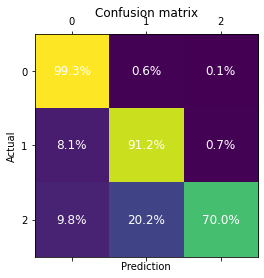

In [89]:
plot_confusion_matrix(conf_mat)

In [109]:
def my_new_dice(preds, labels):
  smooth = 1
  dice = 2 * (preds * labels).sum() / ((preds ** 2 + labels ** 2).sum() + smooth)
  return dice

dice_acc = my_new_dice(vis_pred[:,:,46:-3], vis_labels[:,:,46:-3])
print('The Dice accuracy for single z axis segmentation is %f' % dice_acc)
dice_acc = my_new_dice(vis_final[:,:,46:-3], vis_labels[:,:,46:-3])
print('The Dice accuracy for 3 axes segmentation is %f' % dice_acc)

The Dice accuracy for single z axis segmentation is 0.905159
The Dice accuracy for 3 axes segmentation is 0.915491


# Generate some figures

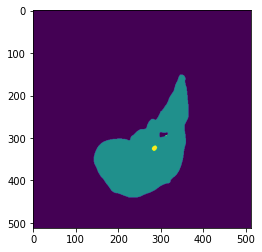

In [128]:
plt.imshow(vis_final[:,:,60])